In [4]:
import json
import pandas as pd
from pathlib import Path

# Define the file path
# file_path = Path(r'F:\Programming\DataMiningProject\data\raw\result.json')
file_path = Path('../data/raw/result.json')

# Check if file exists
if not file_path.exists():
    raise FileNotFoundError(f"File not found at: {file_path}")

# Load the JSON content
with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Normalize data structure:
# Telegram exports often contain a top-level key like "messages".
# We need to extract the list of messages to create a proper DataFrame.
if isinstance(data, dict) and 'messages' in data:
    raw_messages = data['messages']
else:
    raw_messages = data

# Convert to Pandas DataFrame
df = pd.DataFrame(raw_messages)

# Verify loading
print(f"Data Loaded Successfully.")
print(f"Total Raw Records: {len(df)}")
print("\nFirst 3 rows of the DataFrame:")
print(df.head(3))

Data Loaded Successfully.
Total Raw Records: 4596

First 3 rows of the DataFrame:
   id     type                 date date_unixtime               actor  \
0   1  service  2021-09-03T13:57:38    1630661258  معرفی اساتید علموص   
1  12  message  2021-09-05T00:24:19    1630785259                 NaN   
2  13  service  2021-09-05T00:24:25    1630785265  معرفی اساتید علموص   

            actor_id          action               title  \
0  channel1558862150  create_channel  معرفی اساتید علموص   
1                NaN             NaN                 NaN   
2  channel1558862150     pin_message                 NaN   

                                                text  \
0                                                      
1  [{'type': 'hashtag', 'text': '#خبر_مهم'}, \n\n...   
2                                                      

                                       text_entities  ...  width height  \
0                                                 []  ...    NaN    NaN   
1  [{'typ

In [5]:
import re

# ---------------------------------------------------------
# Section 2: Understanding Data Structure (Numeric Statistics)
# ---------------------------------------------------------

# 1. Prepare 'msgs' (Fixing the NameError)
# We filter only actual messages (ignoring service logs)
msgs = df[df['type'] == 'message'].copy()

# Cleaning the text again to ensure we have the 'clean_text' column
def clean_telegram_text(text_obj):
    if isinstance(text_obj, str):
        return text_obj
    elif isinstance(text_obj, list):
        return ''.join([t if isinstance(t, str) else t.get('text', '') for t in text_obj])
    return ""

msgs['clean_text'] = msgs['text'].apply(clean_telegram_text)

# 2. Structure Analysis
# --- Total Messages ---
total_msgs = len(msgs)

# --- Missing Data ---
missing_count = msgs[msgs['clean_text'] == ''].shape[0]

# --- Approximate Professors ---
approx_professors = msgs['clean_text'].nunique()

# --- Score Distribution (Numeric Stats) ---
def extract_rough_scores(text):
    # Find numbers 0-20
    found = re.findall(r'\b(?:20|1\d|[0-9])(?:\.\d+)?\b', text)
    return [float(x) for x in found if 0 <= float(x) <= 20]

all_scores = msgs['clean_text'].apply(extract_rough_scores).explode().dropna().astype(float)

print("--- Section 2: Data Structure Analysis ---")
print(f"1. Total Messages:           {total_msgs}")
print(f"2. Approximate Professors:   {approx_professors} (Unique texts)")
print(f"3. Missing Data:             {missing_count} rows ({(missing_count/total_msgs)*100:.1f}%)")
print(f"4. Score Distribution Stats:")
print(f"   - Mean Score:   {all_scores.mean():.2f}")
print(f"   - Median Score: {all_scores.median():.2f}")
print(f"   - Min/Max:      {all_scores.min()} / {all_scores.max()}")

--- Section 2: Data Structure Analysis ---
1. Total Messages:           4592
2. Approximate Professors:   4546 (Unique texts)
3. Missing Data:             36 rows (0.8%)
4. Score Distribution Stats:
   - Mean Score:   7.64
   - Median Score: 9.00
   - Min/Max:      0.0 / 20.0


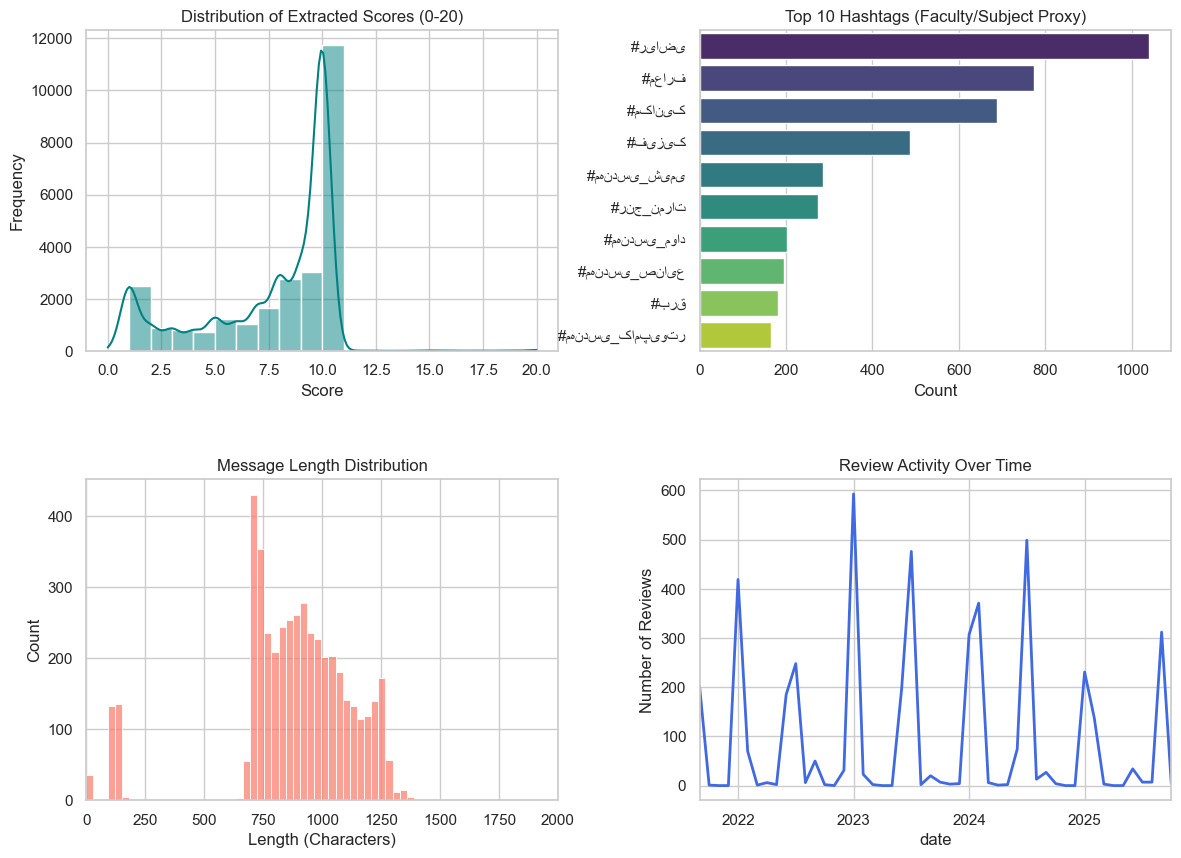

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# ---------------------------------------------------------
# Section 3: Exploratory Plots (Fixed for Seaborn v0.14+)
# ---------------------------------------------------------
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# Create a figure with subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2)
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# --- Plot 1: Score Histogram ---
# Re-extracting scores to ensure this cell is self-contained
def get_scores(text):
    # Find numbers 0-20
    found = re.findall(r'\b(?:20|1\d|[0-9])(?:\.\d+)?\b', text)
    return [float(x) for x in found if 0 <= float(x) <= 20]

all_scores = msgs['clean_text'].apply(get_scores).explode().dropna()

sns.histplot(all_scores, bins=20, kde=True, color='teal', ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Extracted Scores (0-20)')
axes[0, 0].set_xlabel('Score')
axes[0, 0].set_ylabel('Frequency')

# --- Plot 2: Top Hashtags (Faculty/Subject Proxy) ---
# Extract hashtags
def get_hashtags(text_obj):
    if isinstance(text_obj, list):
        return [item['text'] for item in text_obj if isinstance(item, dict) and item.get('type') == 'hashtag']
    return []

all_hashtags = df[df['type'] == 'message']['text'].apply(get_hashtags).explode().dropna()
top_hashtags = Counter(all_hashtags).most_common(10)

if top_hashtags:
    tags, counts = zip(*top_hashtags)
    # FIX: Assigned 'y' to 'hue' and set legend=False to fix the warning
    sns.barplot(x=list(counts), y=list(tags), hue=list(tags), palette='viridis', legend=False, ax=axes[0, 1])
    axes[0, 1].set_title('Top 10 Hashtags (Faculty/Subject Proxy)')
    axes[0, 1].set_xlabel('Count')

# --- Plot 3: Message Length Distribution ---
msgs['msg_length'] = msgs['clean_text'].str.len()
sns.histplot(msgs['msg_length'], bins=50, color='salmon', ax=axes[1, 0])
axes[1, 0].set_title('Message Length Distribution')
axes[1, 0].set_xlabel('Length (Characters)')
axes[1, 0].set_xlim(0, 2000)

# --- Plot 4: Activity Over Time ---
if 'date' in msgs.columns:
    msgs['date'] = pd.to_datetime(msgs['date'])
    monthly_counts = msgs.set_index('date').resample('ME').size()
    monthly_counts.plot(kind='line', color='royalblue', lw=2, ax=axes[1, 1])
    axes[1, 1].set_title('Review Activity Over Time')
    axes[1, 1].set_ylabel('Number of Reviews')

plt.show()